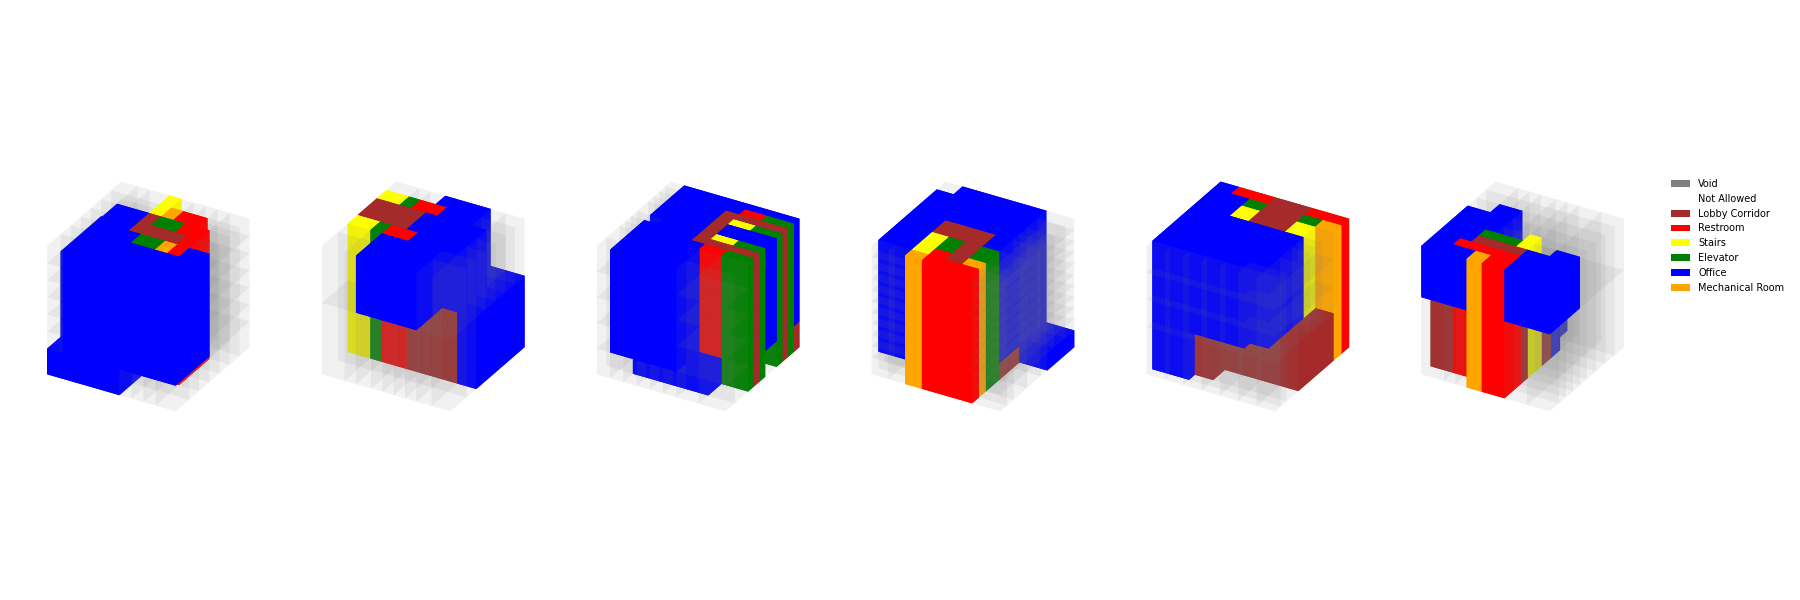

In [1]:
%matplotlib ipympl

import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

sys.path.append(os.path.abspath("../../"))

from building_gan.src import config

data_paths = [
    "../data/6types-raw_data/voxel_data/voxel_005555.json",
    "../data/6types-raw_data/voxel_data/voxel_005556.json",
    "../data/6types-raw_data/voxel_data/voxel_006666.json",
    "../data/6types-raw_data/voxel_data/voxel_006667.json",
    "../data/6types-raw_data/voxel_data/voxel_007777.json",
    "../data/6types-raw_data/voxel_data/voxel_007778.json",
]

col = len(data_paths)
row = 1

fig = plt.figure(figsize=(18, 6))

for di, data_path in enumerate(data_paths):
    with open(data_path, "r") as f:
        data = json.load(f)
    
    subplot = int(f"{row}{col}{di + 1}")
    ax = fig.add_subplot(subplot, projection="3d")
    
    if di == len(data_paths) - 1:
        ax.legend(
            handles=[
                Patch(
                    facecolor=config.ProgramMap.COLORS.value[program.value], 
                    label=program.name.replace("_", " ").title(),
                )
                for program in config.ProgramMap 
                if program.name != "COLORS"
            ], 
            bbox_to_anchor=(1.05, 1), 
            loc="upper left",
            fontsize=7,
            frameon=False,
        )

    for node in data["voxel_node"]:
        z_coo, y_coo, x_coo = node["coordinate"]
        z_dim, y_dim, x_dim = node["dimension"]
        voxel_type = node["type"]
        
        voxel_vertices = [
            [x_coo, y_coo, z_coo], 
            [x_coo+x_dim, y_coo, z_coo], 
            [x_coo+x_dim, y_coo+y_dim, z_coo], 
            [x_coo, y_coo+y_dim, z_coo],
            [x_coo, y_coo, z_coo+z_dim], 
            [x_coo+x_dim, y_coo, z_coo+z_dim], 
            [x_coo+x_dim, y_coo+y_dim, z_coo+z_dim], 
            [x_coo, y_coo+y_dim, z_coo+z_dim]
        ]
        
        voxel_faces = [
            [voxel_vertices[0], voxel_vertices[1], voxel_vertices[2], voxel_vertices[3]],
            [voxel_vertices[4], voxel_vertices[5], voxel_vertices[6], voxel_vertices[7]],
            [voxel_vertices[0], voxel_vertices[1], voxel_vertices[5], voxel_vertices[4]],
            [voxel_vertices[2], voxel_vertices[3], voxel_vertices[7], voxel_vertices[6]],
            [voxel_vertices[1], voxel_vertices[2], voxel_vertices[6], voxel_vertices[5]],
            [voxel_vertices[0], voxel_vertices[3], voxel_vertices[7], voxel_vertices[4]]
        ]
        
        alpha = 0.05 if voxel_type in (-1, -2) else 1.0
        
        voxel = Poly3DCollection(voxel_faces, alpha=alpha)
        voxel.set_facecolor(config.ProgramMap.COLORS.value[voxel_type])
        ax.add_collection3d(voxel)

    ax.set_box_aspect([1, 1, 1])
    ax.set_proj_type("ortho")
    ax._axis3don = False

    # Auto-scale the plot
    all_coords = np.array([node["coordinate"] for node in data["voxel_node"]])
    all_dims = np.array([node["dimension"] for node in data["voxel_node"]])
    max_coords = np.max(all_coords + all_dims, axis=0)
    min_coords = np.min(all_coords, axis=0)

    ax.set_xlim(min_coords[2], max_coords[2])
    ax.set_ylim(min_coords[1], max_coords[1])
    ax.set_zlim(min_coords[0], max_coords[0])

plt.tight_layout()
plt.show()